In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotting_tools as pt
%matplotlib inline

from sklearn import decomposition
import skfuzzy as fuzz
from sklearn import preprocessing

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

def fuzzy_clustering():
    
# exploring the properties of galaxies through multidimensional statistical analysis techniques 
# vespa data, galaxy zoo data, sdss
# 0: stellar mass
# 1: error
# 2: SFR last 115 Myr
# 3: dustVal ISM
# 4: redshift
# 5: prob. elliptical
# 6: prob. spiral
# 7: u
# 8: g
# 9: r
# 10: i
# 11: z
# 12: petro r
# 13: theta

# PCA analysis followed by fuzzy clustering

In [2]:
galaxies = np.load('/home/calum/Documents/Mphys_data/vespa_data/vespa_properties.npy')
len(galaxies)

417270

In [3]:
data = []

for row in galaxies:
    #if (row[4] > 0.004 and row[4] < 0.08) :
        # absolute r-band petrosian magnitude
        x0 = float(row[12])-5*(np.log10(cosmo.luminosity_distance(row[4]).to(u.pc).value/10))
        # u-r colour
        x1 = row[7]-row[9]
        # redshift
        x2 = row[4]
        # morphology
        if row[5] > 0.8:
            # elliptical
            x3 = 1
        elif row[6] > 0.8:
            # spiral
            x3 = -1
        else:
            # should we ommit these?
            x3 = 0
        # ISM dust value
        x4 = row[3]
        # log(stellar mass)
        x5 = np.log(row[0])
        # surface brightness
        x6 = row[9]+2.5*np.log10(2*np.pi*row[13]*row[13])

        # append to data
        data.append([x0,x1,x2,x3,x4,x5,x6])

In [100]:
data = np.array(data)
np.array([[row[1],row[0]] for row in data]).shape

(417270, 2)

In [101]:
# normalising data
data_scale = preprocessing.scale(data,axis=0)
data_scale

array([[ 0.30582942, -0.28163743,  0.25485388, ...,  0.84323204,
        -0.01018306,  0.76888876],
       [-0.42609952,  0.36865139,  0.75071119, ...,  1.40320555,
         0.92674388,  0.81846572],
       [-0.74525811,  1.09892926,  0.4019377 , ...,  0.56324529,
         1.1806057 ,  0.01533326],
       ..., 
       [-0.96776105,  0.79889582,  0.27705993, ...,  0.28325853,
         1.24658344, -0.71207565],
       [-0.77837254, -1.28823172,  1.11697561, ...,  0.84323204,
         0.59969651,  0.68036973],
       [-0.9663502 , -0.15450317,  0.69200971, ...,  0.28325853,
         0.72566846,  1.09097442]])

(-10, 10)

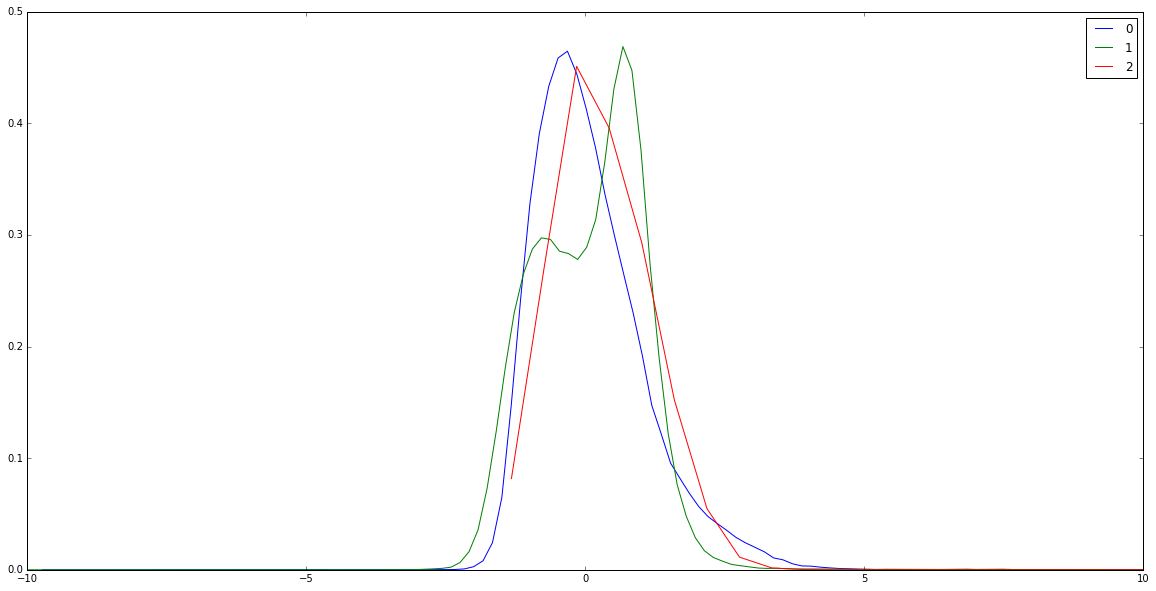

In [102]:
plt.figure(figsize=(20,10))
for i in range(0,3):
    pt.plot_hist([row[i] for row in data_scale],200,str(i))
plt.legend()
plt.xlim(-10,10)

In [103]:
pca = decomposition.PCA(n_components='mle')
data_pca = pca.fit_transform(data_scale)

In [104]:
data_pca.shape

(417270, 6)

(-10, 10)

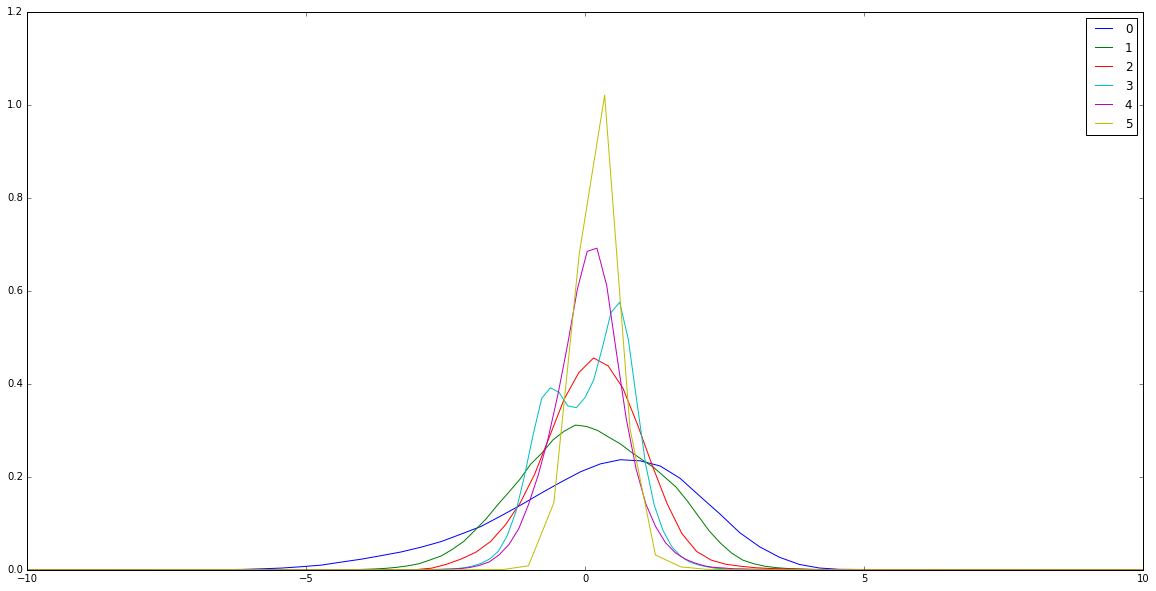

In [105]:
plt.figure(figsize=(20,10))
for i in range(0,6):
    pt.plot_hist([row[i] for row in data_pca],200,str(i))
plt.legend()
plt.xlim(-10,10)

In [122]:
np.array([row[0] for row in data_pca]).shape
data_in = np.array([[row[1]] for row in data if row[2] < 0.08 and row[2] > 0.004])

In [128]:
nclusters = 3
cntr, nu ,u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_in.T,nclusters,2,error=1e-5,maxiter=500)

In [129]:
cluster_membership = np.argmax(nu,axis=0)
cluster_membership.shape

(137166,)

In [130]:
xpts = np.array([row[0] for row in data if row[2] < 0.08 and row[2] > 0.004])
ypts = np.array([row[1] for row in data if row[2] < 0.08 and row[2] > 0.004])

print(xpts.shape)

colors = ['r','g','b']

len(xpts[cluster_membership == 1]),len(xpts[cluster_membership == 0]),len(xpts[cluster_membership == 1])+len(xpts[cluster_membership == 0])

(137166,)


(47385, 46538, 93923)

(1, 4)

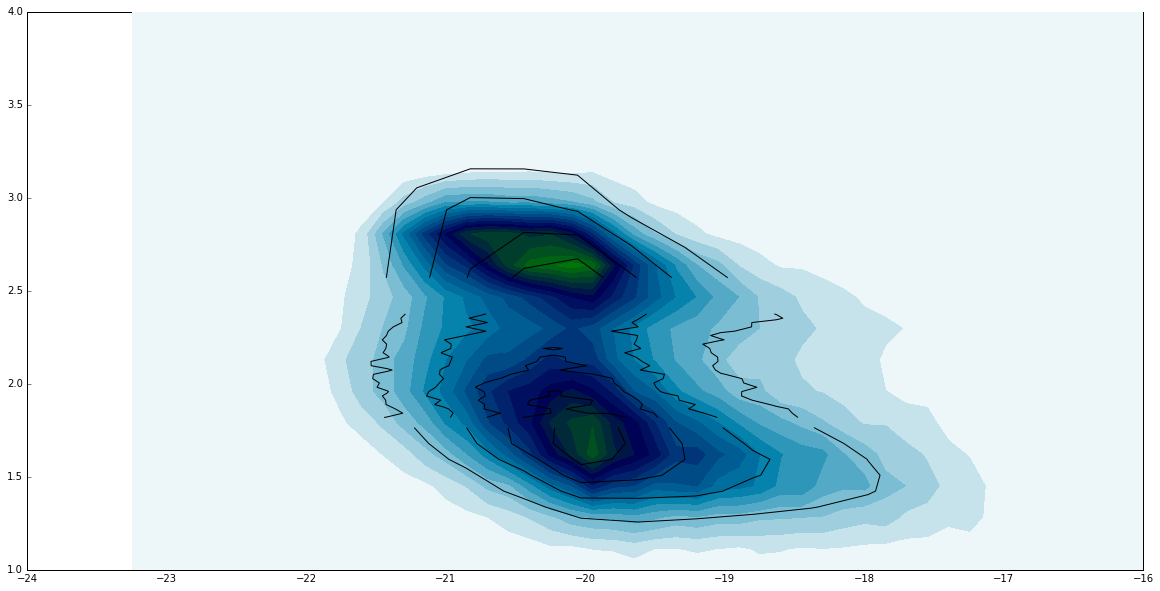

In [139]:
# this is the naive cut only using colour information to select the blue sequence

plt.figure(figsize=(20,10))

pt.plot_contour(xpts,ypts,fill=True,bins=70,lines=20,colours='ocean_r')

for i in range(nclusters):
    pt.plot_contour(xpts[cluster_membership == i],ypts[cluster_membership== i],bins=25,lines=5,colours='k')
    print('')
    

plt.xlim(-24,-16)
plt.ylim(1,4)

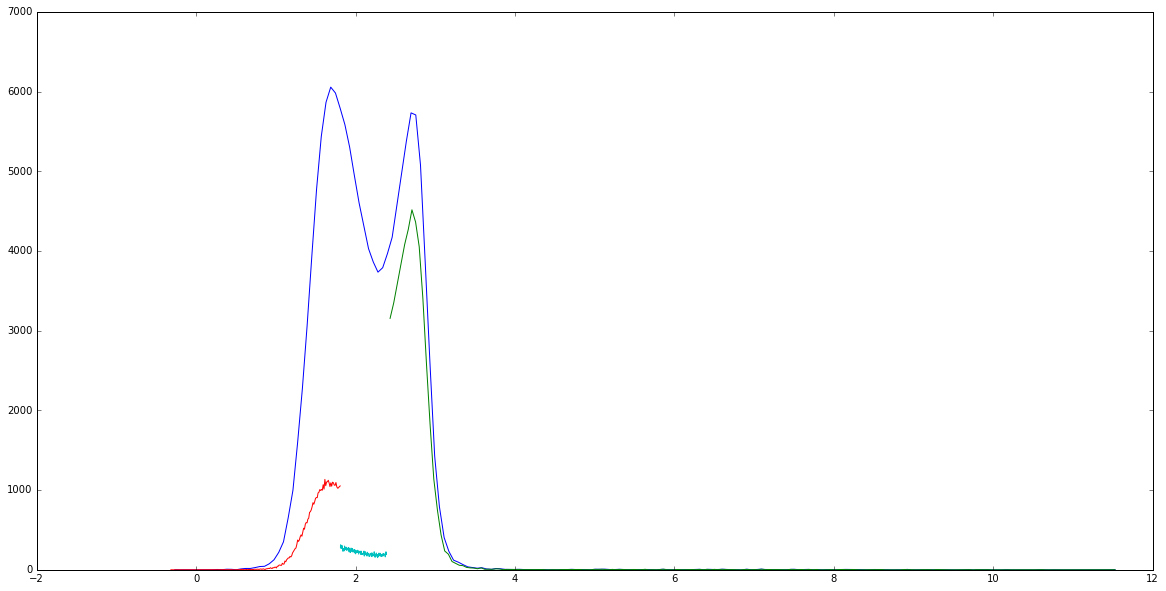

In [151]:
plt.figure(figsize=(20,10))

pt.plot_hist(ypts,200,'one',default=False)
for i in range(nclusters):
    pt.plot_hist(ypts[cluster_membership==i],200,str(i),default=False)



In [159]:
np.max(ypts[cluster_membership==1])

1.8072223663330078